In [2]:
import pandas as pd

csv_file = "../data/discharge.csv"

# Load only the first 1000 rows
df = pd.read_csv(csv_file, nrows=10)

print(df.shape)
# print(df.head())
# print(df.sample(5))
print(df.dtypes)

(10, 8)
note_id       object
subject_id     int64
hadm_id        int64
note_type     object
note_seq       int64
charttime     object
storetime     object
text          object
dtype: object


In [3]:
df.to_csv("../data/discharge_sample_rows_10.csv", index=False)

In [4]:
dataframe = pd.read_csv("../data/discharge_sample_rows_10.csv")
print(dataframe.shape)

(10, 8)


In [ ]:
import pandas as pd
import re
import json

# 1. Read the CSV file
df = pd.read_csv("../data/discharge_sample_rows_10.csv")
print("Initial shape:", df.shape)
print(df.dtypes)

# 2. Clean the text
def clean_text(text):
    # Convert to string, remove newlines/spaces
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    # Remove placeholder underscores if present
    text = text.replace("___", "")
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

# 3. (Optional) Filter for cardiac-related notes
# Comment out this section if you want all discharge notes
cardiac_keywords = ["cardiac", "heart", "myocardial", "coronary", "ECG", "heart failure"]
df = df[df["clean_text"].str.contains("|".join(cardiac_keywords), case=False, na=False)]
print("After cardiac filter:", df.shape)

# 4. Chunk the text (e.g., every 200 words)
def chunk_text(text, chunk_size=200):
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield " ".join(words[i : i + chunk_size])

documents = []
for _, row in df.iterrows():
    note_text = row["clean_text"]
    # Create chunks for each row
    for idx, chunk in enumerate(chunk_text(note_text, chunk_size=250)):
        doc = {
            "note_id": row["note_id"],
            "subject_id": row["subject_id"],
            "hadm_id": row["hadm_id"],
            "note_type": row["note_type"],
            "note_seq": row["note_seq"],
            "charttime": row["charttime"],
            "storetime": row["storetime"],
            "chunk_index": idx,
            "chunk_text": chunk
        }
        documents.append(doc)

# 5. Save the chunked documents to JSON
output_path = "../data/discharge_processed_r10.json"
with open(output_path, "w") as f:
    json.dump(documents, f, indent=2)

print(f"Saved {len(documents)} chunked documents to {output_path}")


Initial shape: (10, 8)
note_id       object
subject_id     int64
hadm_id        int64
note_type     object
note_seq       int64
charttime     object
storetime     object
text          object
dtype: object
After cardiac filter: (6, 9)
Saved 36 chunked documents to ../data/discharge_processed_r10.json


# storing into vector database

In [18]:
import json
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

In [19]:
json_path = "../data/discharge_processed_r10.json"
with open(json_path, "r") as f:
    documents = json.load(f)
print(f"Loaded {len(documents)} documents from {json_path}")

# preparing text for embedding generation
texts = [doc["chunk_text"] for doc in documents]

model = SentenceTransformer("all-MiniLM-L6-v2")

#generating embeddings
embeddings = model.encode(texts, show_progress_bar=True)
print("Embeddings Shape: ", embeddings.shape)

Loaded 36 documents from ../data/discharge_processed_r10.json


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Embeddings Shape:  (36, 384)


In [20]:
# 10. Normalize embeddings for inner product similarity search
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# 11. Create a FAISS index and add the embeddings
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)  # using inner product (cosine similarity when normalized)
index.add(embeddings)
print("FAISS index contains:", index.ntotal, "vectors")

FAISS index contains: 36 vectors


In [21]:
# 12. Perform a sample similarity search with a query
query = "patient with heart failure and myocardial infarction"
query_embedding = model.encode([query])
query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
k = 5  # number of nearest neighbors to retrieve
distances, indices = index.search(query_embedding, k)

In [22]:
print("\nQuery:", query)
print("Top 5 similar document indices:", indices)
print("Distances:", distances)

# 13. Display the corresponding documents from the search results
print("\nRetrieved documents:")
for idx in indices[0]:
    doc = documents[idx]
    print(f"Note ID: {doc['note_id']}, Chunk Index: {doc['chunk_index']}")
    print("Text snippet:", doc["chunk_text"][:200], "...\n")


Query: patient with heart failure and myocardial infarction
Top 5 similar document indices: [[33 20 21 15 34]]
Distances: [[0.42049986 0.39842063 0.387788   0.36556083 0.3582613 ]]

Retrieved documents:
Note ID: 10000764-DS-11, Chunk Index: 3
Text snippet: be determined. There is a trivial/physiologic pericardial effusion. IMPRESSION: Normal left ventricular cavity size with mild regional systolic dysfunction most c/w CAD (distal LAD distribution). Mild ...

Note ID: 10000084-DS-17, Chunk Index: 1
Text snippet: past 24 hours to the point where he has been unable to ambulate on his own. The patient's daughter called his neurologist who recommended presentation to the ED. In the ED, the patient was afebrile, H ...

Note ID: 10000084-DS-17, Chunk Index: 2
Text snippet: History: His mother died at age of "old age." His father died of prostate cancer at . He has an older sister (age and a younger sister (age . He has a younger brother (age . As noted, he has 2 daughte ...

Note ID: 1000003

In [23]:
import os
import pickle
import faiss


In [24]:
# Define paths for saving the index and metadata
faiss_index_path = "../vector_db/faiss_index.index"
metadata_path = "../vector_db/faiss_index_metadata.pkl"

# Create directories for both paths if they don't exist
os.makedirs(os.path.dirname(faiss_index_path), exist_ok=True)
os.makedirs(os.path.dirname(metadata_path), exist_ok=True)

# Save the FAISS index to disk
faiss.write_index(index, faiss_index_path)
print(f"FAISS index persisted to {faiss_index_path}")

FAISS index persisted to ../vector_db/faiss_index.index


In [25]:
# Save the associated document metadata (e.g., note details and chunk info) with pickle
with open(metadata_path, "wb") as f:
    pickle.dump(documents, f)
print(f"Document metadata saved to {metadata_path}")

Document metadata saved to ../vector_db/faiss_index_metadata.pkl


In [26]:
import faiss
import pickle


# Define paths for saving the index and metadata
faiss_index_path = "../vector_db/faiss_index.index"
metadata_path = "../vector_db/faiss_index_metadata.pkl"



# Load the FAISS index from disk
loaded_index = faiss.read_index(faiss_index_path)
print(f"Loaded FAISS index from {faiss_index_path}")

# Load the document metadata
with open(metadata_path, "rb") as f:
    loaded_documents = pickle.load(f)
print(f"Loaded document metadata from {metadata_path}")

# 16. Run a sample similarity search using the loaded index
model = SentenceTransformer("all-MiniLM-L6-v2")

# Define a sample query
query = "patient with heart failure and myocardial infarction"

# Generate and normalize the query embedding using the same SentenceTransformer model
query_embedding = model.encode([query])
query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

# Perform a similarity search for the top 5 matches
k = 5
distances, indices = loaded_index.search(query_embedding, k)

print("\nQuery:", query)
print("Top similar document indices:", indices)
print("Distances:", distances)

# 17. Display the corresponding documents based on the search results
print("\nRetrieved documents:")
for idx in indices[0]:
    doc = loaded_documents[idx]
    print(f"Note ID: {doc['note_id']}, Chunk Index: {doc['chunk_index']}")
    print("Text snippet:", doc["chunk_text"][:200], "...\n")

Loaded FAISS index from ../vector_db/faiss_index.index
Loaded document metadata from ../vector_db/faiss_index_metadata.pkl

Query: patient with heart failure and myocardial infarction
Top similar document indices: [[33 20 21 15 34]]
Distances: [[0.42049986 0.39842063 0.387788   0.36556083 0.3582613 ]]

Retrieved documents:
Note ID: 10000764-DS-11, Chunk Index: 3
Text snippet: be determined. There is a trivial/physiologic pericardial effusion. IMPRESSION: Normal left ventricular cavity size with mild regional systolic dysfunction most c/w CAD (distal LAD distribution). Mild ...

Note ID: 10000084-DS-17, Chunk Index: 1
Text snippet: past 24 hours to the point where he has been unable to ambulate on his own. The patient's daughter called his neurologist who recommended presentation to the ED. In the ED, the patient was afebrile, H ...

Note ID: 10000084-DS-17, Chunk Index: 2
Text snippet: History: His mother died at age of "old age." His father died of prostate cancer at . He has an older

In [27]:
print(loaded_documents[8]["chunk_text"])


NO MICROORGANISMS SEEN. This is a concentrated smear made by cytospin method, please refer to hematology for a quantitative white blood cell count.. FLUID CULTURE (Final : NO GROWTH. ANAEROBIC CULTURE (Preliminary): NO GROWTH. Diagnositc Para: 07:00PM ASCITES 07:00PM ASCITES IMAGING: CXR- No acute cardiopulmonary abnormality. RUQ US- 1. Extremely coarse and nodular liver echotexture consistent with a history of cirrhosis. 2. Moderate ascites. 3. Patent portal vein. Brief Hospital Course: with HIV on HAART, HCV cirrhosis with ascites and HE, h/o IVDU, COPD, bipolar disorder presents with abdominal discomfort due to ascites. # ASCITES. Now diuretic refractory given last tap was three days ago with 3L removed and she has already built up moderate ascites. Infectious workup negative, with CXR clear, UA contaminated but not grossly positive so will f/u culture, diagnostic para with only 225 WBC, RUQ US with no PV thrombus. Compliant with diuretics but not following low sodium diet or fluid 

In [28]:
import json
import re
from sklearn.metrics import f1_score
import pandas as pd

# Utility functions
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# Load responses.json
with open('../data/responses.json', 'r') as f:
    data = json.load(f)

results = []

# Evaluate each item
for item in data:
    q = item['query']
    pred = item['response']
    true = item['original_answer']
    
    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)
    
    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3)
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display average scores
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()

print("\nEvaluation Results")
print("-------------------")
print(df[['question', 'exact_match', 'f1_score']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

# Save to CSV (optional)
df.to_csv("evaluation_results.csv", index=False)
print("\nSaved detailed results to evaluation_results.csv")



Evaluation Results
-------------------
                                            question  exact_match  f1_score
0  What is the MELD score of the patient on admis...            0     0.462
1  What medications were discontinued due to high...            0     0.222
2  What procedure was used to remove fluid from t...            0     0.000
3  What is the dosage of furosemide prescribed on...            0     0.133
4  Was the patient scheduled for outpatient parac...            0     0.000
5  What dietary instructions were given on discha...            0     0.138
6      What is the patient’s diagnosis on discharge?            0     0.073
7  What were the lab values for serum sodium on a...            0     0.000
8  What medications were prescribed for hepatic e...            0     0.348
9  What was the reason for the therapeutic parace...            0     0.345

Average Exact Match: 0.00
Average F1 Score: 0.17

Saved detailed results to evaluation_results.csv


In [1]:
import json
import re
from sklearn.metrics import f1_score
import pandas as pd

# Utility functions
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# Load responses.json
with open('../data/responses_v2.json', 'r') as f:
    data = json.load(f)

results = []

# Evaluate each item
for item in data:
    q = item['query']
    pred = item['response']
    true = item['original_answer']
    
    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)
    
    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3)
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display average scores
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()

print("\nEvaluation Results")
print("-------------------")
print(df[['question', 'exact_match', 'f1_score']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

# Save to CSV (optional)
df.to_csv("evaluation_results.csv", index=False)
print("\nSaved detailed results to evaluation_results_v2.csv")



Evaluation Results
-------------------
                                            question  exact_match  f1_score
0  What is the MELD score of the patient on admis...            0     0.462
1  What medications were discontinued due to high...            0     0.000
2  What procedure was used to remove fluid from t...            0     0.000
3  What is the dosage of furosemide prescribed on...            0     0.000
4  Was the patient scheduled for outpatient parac...            0     0.000
5  What dietary instructions were given on discha...            0     0.476
6      What is the patient’s diagnosis on discharge?            0     0.000
7  What were the lab values for serum sodium on a...            0     0.000
8  What medications were prescribed for hepatic e...            0     0.061
9  What was the reason for the therapeutic parace...            0     0.080

Average Exact Match: 0.00
Average F1 Score: 0.11

Saved detailed results to evaluation_results_v2.csv


In [3]:
import json
import re
from sklearn.metrics import f1_score
import pandas as pd

# Utility functions
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# Load responses.json
with open('../data/responses_v5.json', 'r') as f:
    data = json.load(f)

results = []

# Evaluate each item
for item in data:
    q = item['query']
    pred = item['gemini_answer']
    true = item['original_answer']
    
    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)
    
    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3)
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display average scores
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()

print("\nEvaluation Results")
print("-------------------")
print(df[['question', 'exact_match', 'f1_score']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

# Save to CSV (optional)
df.to_csv("evaluation_results.csv", index=False)
print("\nSaved detailed results to evaluation_results_v3.csv")



Evaluation Results
-------------------
                                            question  exact_match  f1_score
0  What is the MELD score of the patient on admis...            0     0.500
1  What medications were discontinued due to high...            0     0.111
2  What procedure was used to remove fluid from t...            0     0.067
3  Was the patient scheduled for outpatient parac...            0     0.000
4  What dietary instructions were given on discha...            0     0.250
5      What is the patient’s diagnosis on discharge?            0     0.000
6  What were the lab values for serum sodium on a...            0     0.154
7  What was the reason for the therapeutic parace...            0     0.308

Average Exact Match: 0.00
Average F1 Score: 0.17

Saved detailed results to evaluation_results_v3.csv


In [5]:
import json
import re
from sklearn.metrics import f1_score
import pandas as pd

# Utility functions
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# Load responses.json
with open('../data/map_reduce_responses.json', 'r') as f:
    data = json.load(f)

results = []

# Evaluate each item
for item in data:
    q = item['query']
    pred = item['gemini_answer']
    true = item['original_answer']
    
    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)
    
    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3)
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display average scores
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()

print("\nEvaluation Results")
print("-------------------")
print(df[['question', 'exact_match', 'f1_score']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

# Save to CSV (optional)
df.to_csv("evaluation_results_via_map_reduce.csv", index=False)
print("\nSaved detailed results to evaluation_results_via_map_reduce.csv")



Evaluation Results
-------------------
                                            question  exact_match  f1_score
0  What is the MELD score of the patient on admis...            0     0.500
1  What medications were discontinued due to high...            0     0.111
2  What procedure was used to remove fluid from t...            0     0.067
3  What is the dosage of furosemide prescribed on...            0     0.261
4  Was the patient scheduled for outpatient parac...            0     0.000
5  What dietary instructions were given on discha...            0     0.174
6      What is the patient’s diagnosis on discharge?            0     0.000
7  What were the lab values for serum sodium on a...            0     0.154
8  What medications were prescribed for hepatic e...            0     0.294
9  What was the reason for the therapeutic parace...            0     0.324

Average Exact Match: 0.00
Average F1 Score: 0.19

Saved detailed results to evaluation_results_via_map_reduce.csv


In [6]:
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# New helper: is ground truth in sources?
def is_answer_in_sources(answer, sources):
    normalized_answer = normalize(answer)
    for doc in sources:
        if normalized_answer in normalize(doc):
            return True
    return False

# New helper: check for abstention
def is_abstaining(pred):
    pred = normalize(pred)
    return any(x in pred for x in ["not available", "insufficient", "no information", "unknown", "not provided"])

results = []

with open('../data/map_reduce_responses.json', 'r') as f:
    data = json.load(f)

for item in data:
    q = item['query']
    pred = item['gemini_answer']
    true = item['original_answer']
    sources = item['source_documents']

    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)

    # New logic
    answer_present = is_answer_in_sources(true, sources)
    abstained = is_abstaining(pred)
    correct_abstention = int(abstained and not answer_present)
    hallucinated = int(abstained and answer_present)

    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3),
        "abstained": abstained,
        "correct_abstention": correct_abstention,
        "hallucinated": hallucinated
    })

# Create DataFrame
df = pd.DataFrame(results)

# Summary
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()
correct_abstention_rate = df['correct_abstention'].mean()
hallucination_rate = df['hallucinated'].mean()

# Filter out correct abstentions with zero F1 (they didn't try to answer)
filtered_df = df[~((df['f1_score'] == 0.0) & (df['correct_abstention'] == 1))]

# Adjusted F1 (only for attempted answers or failed attempts that were not abstentions)
adjusted_f1 = filtered_df['f1_score'].mean()

print(f"\nAdjusted F1 Score (excluding correct abstentions): {adjusted_f1:.2f}")


print("\nEvaluation Results")
print("-------------------")
print(df[['question', 'exact_match', 'f1_score', 'correct_abstention', 'hallucinated']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")
print(f"Correct Abstention Rate: {correct_abstention_rate:.2f}")
print(f"Hallucination Rate: {hallucination_rate:.2f}")

df.to_csv("evaluation_with_abstention_analysis.csv", index=False)
print("\nSaved results to evaluation_with_abstention_analysis.csv")



Adjusted F1 Score (excluding correct abstentions): 0.21

Evaluation Results
-------------------
                                            question  exact_match  f1_score  \
0  What is the MELD score of the patient on admis...            0     0.500   
1  What medications were discontinued due to high...            0     0.111   
2  What procedure was used to remove fluid from t...            0     0.067   
3  What is the dosage of furosemide prescribed on...            0     0.261   
4  Was the patient scheduled for outpatient parac...            0     0.000   
5  What dietary instructions were given on discha...            0     0.174   
6      What is the patient’s diagnosis on discharge?            0     0.000   
7  What were the lab values for serum sodium on a...            0     0.154   
8  What medications were prescribed for hepatic e...            0     0.294   
9  What was the reason for the therapeutic parace...            0     0.324   

   correct_abstention  hallucinat


Faithfulness Evaluation
------------------------
                                            question  faithful
0  What is the MELD score of the patient on admis...         1
1  What medications were discontinued due to high...         1
2  What procedure was used to remove fluid from t...         0
3  What is the dosage of furosemide prescribed on...         1
4  Was the patient scheduled for outpatient parac...         1
5  What dietary instructions were given on discha...         1
6      What is the patient’s diagnosis on discharge?         0
7  What were the lab values for serum sodium on a...         0
8  What medications were prescribed for hepatic e...         0
9  What was the reason for the therapeutic parace...         0

Faithful Response Rate: 0.50


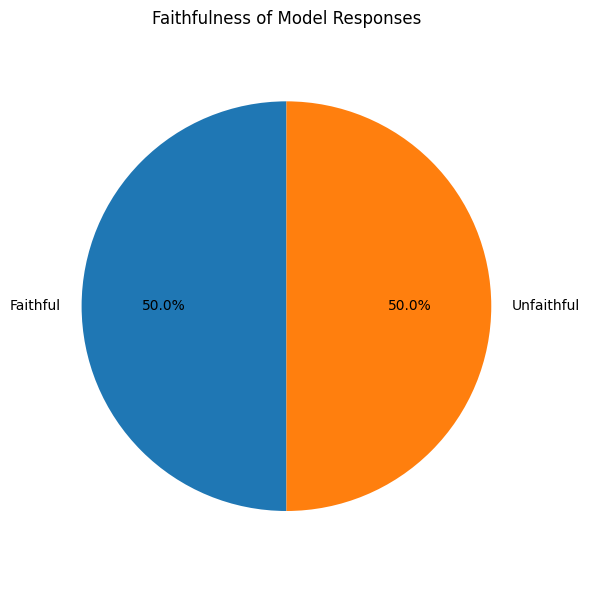

In [7]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

# ---------- UTILITY FUNCTIONS ----------
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def is_faithful(pred, sources):
    norm_pred = normalize(pred)
    return any(norm_pred in normalize(doc) or normalize(doc) in norm_pred for doc in sources)

# ---------- LOAD DATA ----------
with open("../data/map_reduce_responses.json", "r") as f:
    data = json.load(f)

faithfulness_results = []

for item in data:
    question = item["query"]
    pred = item["gemini_answer"]
    sources = item["source_documents"]

    faithful = is_faithful(pred, sources)
    
    faithfulness_results.append({
        "question": question,
        "model_answer": pred,
        "faithful": int(faithful)
    })

# ---------- CREATE DATAFRAME ----------
df_faithful = pd.DataFrame(faithfulness_results)
faithful_rate = df_faithful["faithful"].mean()

# ---------- DISPLAY RESULTS ----------
print("\nFaithfulness Evaluation")
print("------------------------")
print(df_faithful[["question", "faithful"]])
print(f"\nFaithful Response Rate: {faithful_rate:.2f}")

# ---------- VISUALIZATION ----------
labels = ["Faithful", "Unfaithful"]
values = [
    df_faithful["faithful"].sum(),
    len(df_faithful) - df_faithful["faithful"].sum()
]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Faithfulness of Model Responses")
plt.axis("equal")
plt.tight_layout()
plt.show()


# ROUGE Evaluation block

In [11]:
import json
import re
import pandas as pd
from rouge_score import rouge_scorer

# Utility functions
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

def is_answer_in_sources(answer, sources):
    normalized_answer = normalize(answer)
    for doc in sources:
        if normalized_answer in normalize(doc):
            return True
    return False

def is_abstaining(pred):
    pred = normalize(pred)
    return any(x in pred for x in ["not available", "insufficient", "no information", "unknown", "not provided"])

# Load your JSON file
with open('../data/map_reduce_responses.json', 'r') as f:
    data = json.load(f)

# Set up the scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

results = []

# Evaluate
for item in data:
    q = item['query']
    pred = item['gemini_answer']
    true = item['original_answer']
    sources = item['source_documents']

    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)
    rougeL = scorer.score(pred, true)['rougeL'].fmeasure

    abstained = is_abstaining(pred)
    answer_present = is_answer_in_sources(true, sources)
    correct_abstention = int(abstained and not answer_present)
    hallucinated = int(abstained and answer_present)

    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3),
        "rougeL": round(rougeL, 3),
        "correct_abstention": correct_abstention,
        "hallucinated": hallucinated
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display results
avg_rougeL = df['rougeL'].mean()

print("ROUGE-L Evaluation")
print("-------------------")
print(df[['question', 'rougeL']])
print(f"\nAverage ROUGE-L Score: {avg_rougeL:.2f}")

# Optional: Save to CSV
df.to_csv("evaluation_with_rougeL.csv", index=False)
print("\nSaved results to evaluation_with_rougeL.csv")


ROUGE-L Evaluation
-------------------
                                            question  rougeL
0  What is the MELD score of the patient on admis...   0.462
1  What medications were discontinued due to high...   0.095
2  What procedure was used to remove fluid from t...   0.056
3  What is the dosage of furosemide prescribed on...   0.286
4  Was the patient scheduled for outpatient parac...   0.080
5  What dietary instructions were given on discha...   0.222
6      What is the patient’s diagnosis on discharge?   0.000
7  What were the lab values for serum sodium on a...   0.133
8  What medications were prescribed for hepatic e...   0.350
9  What was the reason for the therapeutic parace...   0.140

Average ROUGE-L Score: 0.18

Saved results to evaluation_with_rougeL.csv


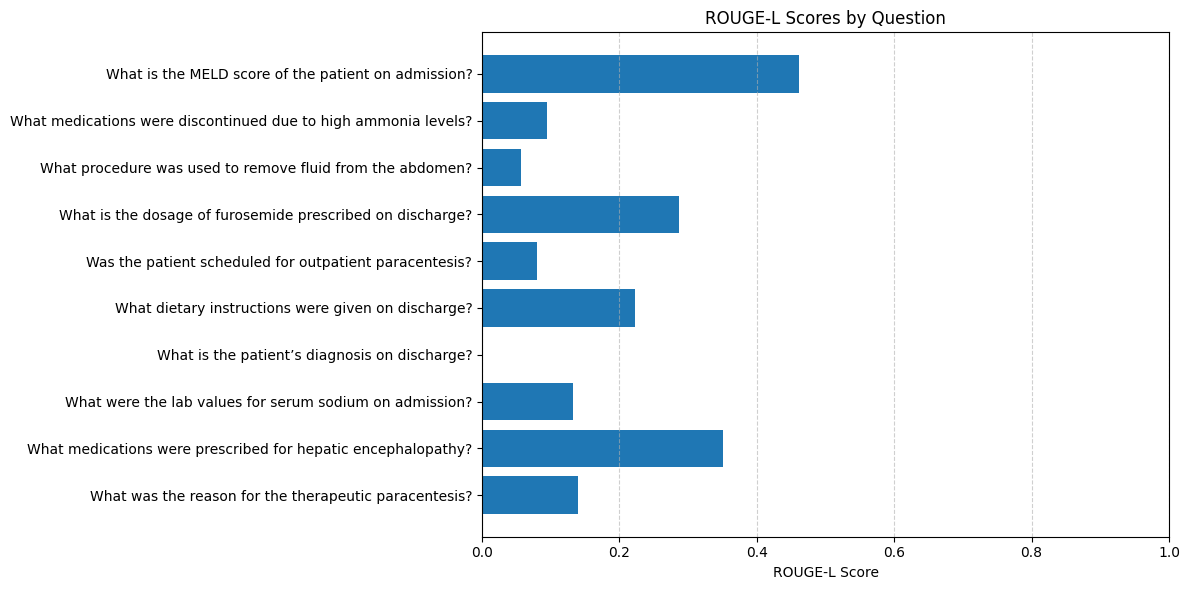

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the dataframe with ROUGE-L scores
data = {
    "question": [
        "What is the MELD score of the patient on admission?",
        "What medications were discontinued due to high ammonia levels?",
        "What procedure was used to remove fluid from the abdomen?",
        "What is the dosage of furosemide prescribed on discharge?",
        "Was the patient scheduled for outpatient paracentesis?",
        "What dietary instructions were given on discharge?",
        "What is the patient’s diagnosis on discharge?",
        "What were the lab values for serum sodium on admission?",
        "What medications were prescribed for hepatic encephalopathy?",
        "What was the reason for the therapeutic paracentesis?"
    ],
    "rougeL": [0.462, 0.095, 0.056, 0.286, 0.080, 0.222, 0.000, 0.133, 0.350, 0.140]
}

df_rouge = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(df_rouge['question'], df_rouge['rougeL'])
plt.xlabel("ROUGE-L Score")
plt.title("ROUGE-L Scores by Question")
plt.xlim(0, 1)
plt.tight_layout()
plt.gca().invert_yaxis()  # Show the best scores on top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
    import json
    import re
    import pandas as pd
    from bert_score import score as bert_score

    # Utility functions
    def normalize(text):
        return re.sub(r'\s+', ' ', text.strip().lower())

    # Load your JSON data
    with open('../data/map_reduce_responses.json', 'r') as f:
        data = json.load(f)

    # Extract predictions and references
    preds = [item['gemini_answer'] for item in data]
    refs = [item['original_answer'] for item in data]

    # Compute BERTScore
    P, R, F1 = bert_score(preds, refs, lang="en", verbose=True)

    # Round scores for reporting
    bert_results = [{
        "question": item['query'],
        "ground_truth": refs[i],
        "model_answer": preds[i],
        "bert_precision": round(P[i].item(), 3),
        "bert_recall": round(R[i].item(), 3),
        "bert_f1": round(F1[i].item(), 3)
    } for i, item in enumerate(data)]

    # Create DataFrame
    df_bert = pd.DataFrame(bert_results)

    # Display
    avg_bert_f1 = df_bert['bert_f1'].mean()
    print("\nBERTScore Evaluation")
    print("---------------------")
    print(df_bert[['question', 'bert_f1']])
    print(f"\nAverage BERT F1 Score: {avg_bert_f1:.2f}")

    # Save if needed
    df_bert.to_csv("evaluation_with_bertscore.csv", index=False)
    print("\nSaved results to evaluation_with_bertscore.csv")

model.safetensors:  43%|####2     | 608M/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.86 seconds, 2.59 sentences/sec

BERTScore Evaluation
---------------------
                                            question  bert_f1
0  What is the MELD score of the patient on admis...    0.874
1  What medications were discontinued due to high...    0.901
2  What procedure was used to remove fluid from t...    0.845
3  What is the dosage of furosemide prescribed on...    0.841
4  Was the patient scheduled for outpatient parac...    0.805
5  What dietary instructions were given on discha...    0.871
6      What is the patient’s diagnosis on discharge?    0.776
7  What were the lab values for serum sodium on a...    0.788
8  What medications were prescribed for hepatic e...    0.886
9  What was the reason for the therapeutic parace...    0.863

Average BERT F1 Score: 0.85

Saved results to evaluation_with_bertscore.csv


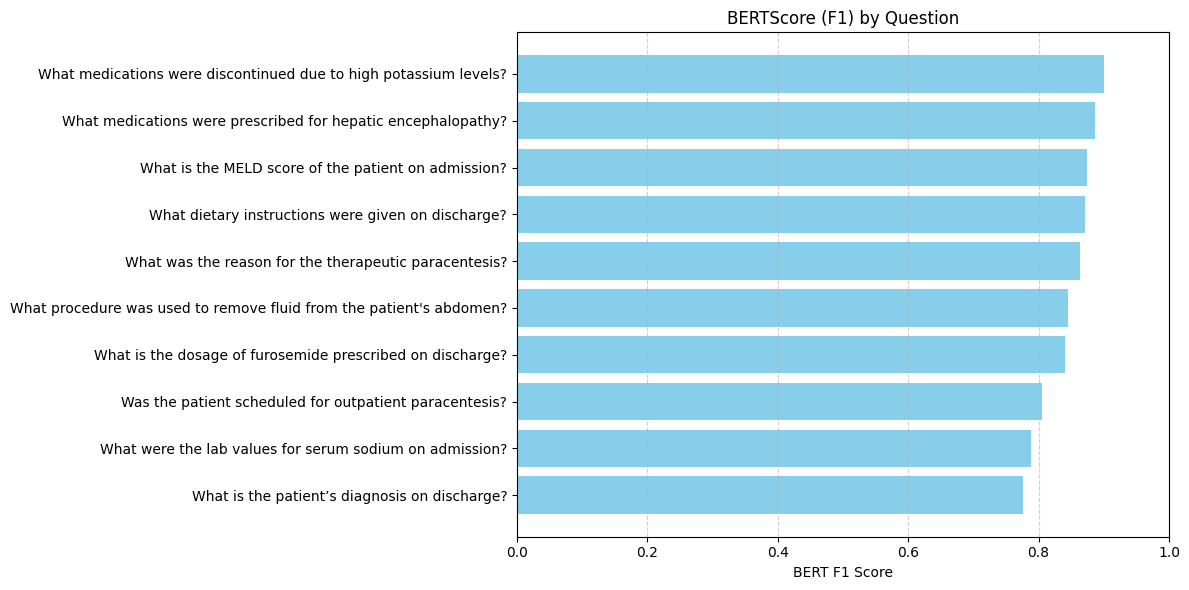

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df_bert = pd.read_csv("evaluation_with_bertscore.csv")
df_bert = df_bert.sort_values(by="bert_f1", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_bert["question"], df_bert["bert_f1"], color='skyblue')
plt.xlabel("BERT F1 Score")
plt.title("BERTScore (F1) by Question")
plt.xlim(0, 1)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [7]:
import json
import re
import pandas as pd
from bert_score import score as bert_score

# Utility functions
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

# Load your JSON data
with open('../data/output_data/map_reduce_responses_generation.json', 'r') as f:
    data = json.load(f)

# Extract predictions and references
preds = [item['gemini_answer'] for item in data]
refs = [item['original_answer'] for item in data]

# Compute BERTScore
P, R, F1 = bert_score(preds, refs, lang="en", verbose=True)

# Round scores for reporting
bert_results = [{
    "question": item['query'],
    "ground_truth": refs[i],
    "model_answer": preds[i],
    "bert_precision": round(P[i].item(), 3),
    "bert_recall": round(R[i].item(), 3),
    "bert_f1": round(F1[i].item(), 3)
} for i, item in enumerate(data)]

# Create DataFrame
df_bert = pd.DataFrame(bert_results)

# Display
avg_bert_f1 = df_bert['bert_f1'].mean()
print("\nBERTScore Evaluation")
print("---------------------")
print(df_bert[['question', 'bert_f1']])
print(f"\nAverage BERT F1 Score: {avg_bert_f1:.2f}")

# Save if needed
df_bert.to_csv("evaluation_with_bertscore.csv", index=False)
print("\nSaved results to evaluation_with_bertscore.csv")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 7.93 seconds, 2.39 sentences/sec

BERTScore Evaluation
---------------------
                                             question  bert_f1
0                     What symptoms led to admission?    0.838
1         What is the furosemide dosage on discharge?    0.863
2   What dietary instructions were provided on dis...    0.882
3                     What symptoms led to admission?    0.838
4   What dietary instructions were provided on dis...    0.874
5                   What is the patient's MELD score?    0.871
6         What is the furosemide dosage on discharge?    0.857
7   What dietary instructions were provided on dis...    0.874
8                     What symptoms led to admission?    0.837
9   What medication was prescribed for hepatic enc...    0.886
10        What is the furosemide dosage on discharge?    0.857
11        What is the furosemide dosage on discharge?    0.857
12                    What symptoms led to admission?    0.838
13                   What is the 

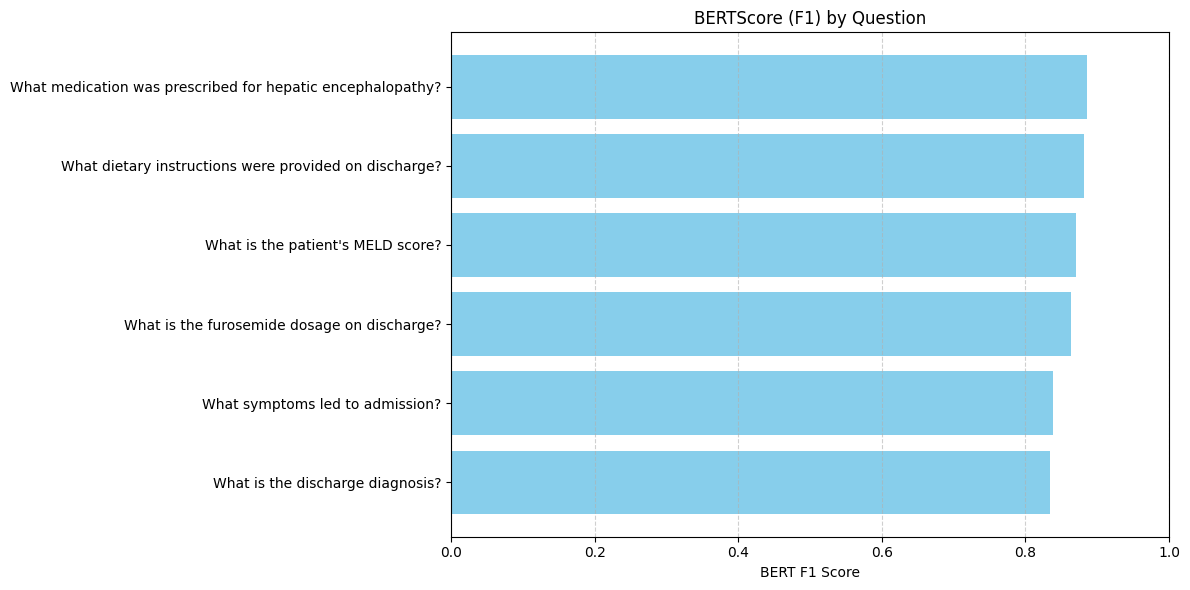

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_bert = pd.read_csv("evaluation_with_bertscore.csv")
df_bert = df_bert.sort_values(by="bert_f1", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_bert["question"], df_bert["bert_f1"], color='skyblue')
plt.xlabel("BERT F1 Score")
plt.title("BERTScore (F1) by Question")
plt.xlim(0, 1)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [5]:
import json
import re
import pandas as pd

# Normalize text
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# Load dataset
with open('../../data/evaluation/eval_result/map_reduce_responses_generation.json', 'r') as f:
    data = json.load(f)

# Evaluate
results = []
for item in data:
    em = exact_match(item['gemini_answer'], item['original_answer'])
    f1 = f1_score_single(item['gemini_answer'], item['original_answer'])
    results.append({
        "question": item['query'],
        "exact_match": em,
        "f1_score": round(f1, 3)
    })

df = pd.DataFrame(results)
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()

# Print results
print("\nExact Match & F1 Score")
print("-----------------------")
print(df[['question', 'exact_match', 'f1_score']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

df.to_csv("evaluation_em_f1.csv", index=False)
print("\nSaved results to evaluation_em_f1.csv")



Exact Match & F1 Score
-----------------------
                                             question  exact_match  f1_score
0                     What symptoms led to admission?            0     0.160
1         What is the furosemide dosage on discharge?            0     0.263
2   What dietary instructions were provided on dis...            0     0.240
3                     What symptoms led to admission?            0     0.167
4   What dietary instructions were provided on dis...            0     0.190
5                   What is the patient's MELD score?            0     0.462
6         What is the furosemide dosage on discharge?            0     0.242
7   What dietary instructions were provided on dis...            0     0.190
8                     What symptoms led to admission?            0     0.151
9   What medication was prescribed for hepatic enc...            0     0.258
10        What is the furosemide dosage on discharge?            0     0.242
11        What is the furose

In [4]:
import json
import re
import pandas as pd
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Load dataset
with open("../../data/evaluation/eval_result/map_reduce_responses_generation.json", 'r') as f:
    data = json.load(f)

# Evaluate
rouge_results = []
for item in data:
    scores = scorer.score(item['original_answer'], item['gemini_answer'])
    rougeL_f1 = round(scores['rougeL'].fmeasure, 3)
    rouge_results.append({
        "question": item['query'],
        "rougeL": rougeL_f1
    })

df_rouge = pd.DataFrame(rouge_results)
avg_rougeL = df_rouge['rougeL'].mean()

# Print results
print("\nROUGE-L Evaluation")
print("-------------------")
print(df_rouge[['question', 'rougeL']])
print(f"\nAverage ROUGE-L Score: {avg_rougeL:.2f}")

df_rouge.to_csv("evaluation_with_rougeL.csv", index=False)
print("\nSaved results to evaluation_with_rougeL.csv")



ROUGE-L Evaluation
-------------------
                                             question  rougeL
0                     What symptoms led to admission?   0.164
1         What is the furosemide dosage on discharge?   0.200
2   What dietary instructions were provided on dis...   0.345
3                     What symptoms led to admission?   0.169
4   What dietary instructions were provided on dis...   0.333
5                   What is the patient's MELD score?   0.429
6         What is the furosemide dosage on discharge?   0.256
7   What dietary instructions were provided on dis...   0.333
8                     What symptoms led to admission?   0.152
9   What medication was prescribed for hepatic enc...   0.244
10        What is the furosemide dosage on discharge?   0.256
11        What is the furosemide dosage on discharge?   0.256
12                    What symptoms led to admission?   0.164
13                   What is the discharge diagnosis?   0.118
14                    What sym